## Introduzione

In questa esercitazione utilizzeremo del machine learning, nello specifico deep Neural Networks, per eseguire fit di funzioni a partire da dati con rumore. L'obiettivo è capire come la struttura del NN influenzi la qualità del fit.

### Il problema delle predizioni

Generiamo un dataset $(x,y)$ che potrebbe arrivare da un generico processo probabilistico secondo la seguente equazione:
$$
    y_i= f(x_i) + \eta_i,
$$

con $f(x_i)$ che rappresenta il modello che vogliamo descrivere, e $\eta_i$ rumore gaussiano scorrelato, ovvero:

$$
\langle \eta_i \rangle=0 \\
\langle \eta_i \eta_j \rangle = \delta_{ij} \sigma
$$

Concsideriamo quindi una rete neurale dove i parametri liberi sono rappresentati dai pesi $w$ e dai bias $h$ associati ad ogni neurone. Per definire i parametri che meglio rappresentano i dati è necessario considerare un primo dataset, chiamato set di training, su quali si allenerà il modello. L'altro set, di dimensioni più ridotte, serve per testare il modello precedentemente allenato. Quello che ci interessa infatti è che la rete neurale sia in grado di generalizzare quanto imparato sui dati iniziali in condizioni nuove. Siamo perciò interessati a evitare l'overfitting, fenomeno per cui la rete neurale inizia a imparare caratteristiche specifiche dei soli dati di training.

L'allenamento viene fatto minimizzando una certa funzione di costo, nel nostro caso l'errore quadratico medio:
$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$

Il processo di ricerca del minimo può essere fatto utilizzando diversi algoritmi: alcune scelte standard possono essere la discesa stocastica del gradiente "SGD" oppure l'algoritmo "Adam".

### Esercizio 11.1

Cerchiamo di fare il fit di una semplice funzione lineare:

$$
f(x)=2x+1
$$

Questo caso risulta essere abbastanza speciale perché i neuroni funzionano esattamente come funzioni lineari. Considerato questo fatto, un solo strato con un solo neurone deve quindi essere sufficiente (e in un certo senso è anche la scelta migliore) per un buon fit.

In un modello di questo tipo i parametri che si possono modificare sono quindi tre:

1. $N_{train}$ ovvero il numero di dati di training.
2. $N_{epochs}$ ovvero il numero di epoche usato per far lavorare l'ottimizzazione.
3. $\sigma$ ovvero la quantità di rumore con cui si generano i dati iniziali.

Facendo alcune prove, probabilmente a causa della semplicità del modello, ci si è resi conto che non è necessario aumentare i punti di training. Per questo motivo si è tenuto $N_{train}=500$ per ogni simulazione (alle saranno fine alcuni commenti sull'opportunità di ridurre il numero di dati di training). Per quanto riguarda i dati di test invece, ne generiamo sempre in quantità $\frac{1}{10}N_{train}$. Si è quindi proceduto a generare dati con rumori via via maggiori e a analizzare la velocità di apprendimento della rete.

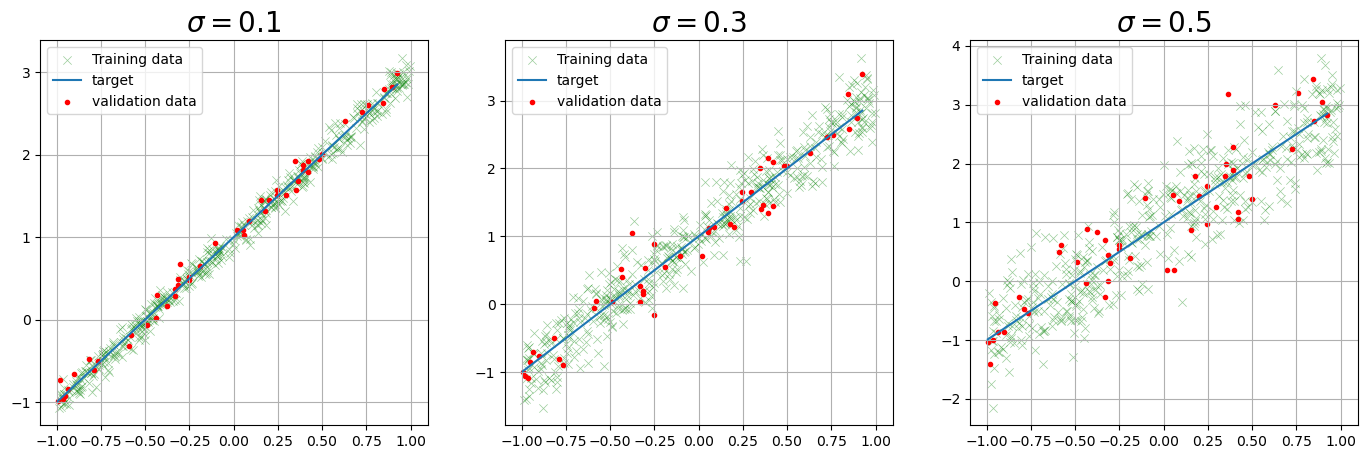

In [45]:
import numpy as np
import matplotlib.pyplot as plt


# generate training inputs
np.random.seed(0)
x_train = np.random.uniform(-1, 1, 500)
x_valid = np.random.uniform(-1, 1, 50)
x_valid.sort()

m = 2 # slope
b = 1 # intersect
y_target = m * x_valid + b # ideal (target) linear function

sigma = [0.1, 0.3, 0.5] # noise standard deviation, for the moment it is absent
sigmas= ["0.1", "0.3", "0.5"]

y_train = np.zeros((3, len(x_train)))  # Define y_train as a matrix
y_valid = np.zeros((3, len(x_valid)))  # Define y_valid as a matrix

plt.figure(figsize=(17,5))
for i in range (3):
    plt.subplot(1,3,i+1)
    y_train[i] = np.random.normal(m * x_train + b, sigma[i]) # actual measures from which we want to guess regression parameters
    y_valid[i] = np.random.normal(m * x_valid + b, sigma[i])
    plt.scatter(x_train, y_train[i], marker = "x", color='green', label='Training data',linewidth=0.5, alpha=0.4)
    plt.plot(x_valid, y_target, label='target')
    plt.scatter(x_valid, y_valid[i], color='r', label='validation data', marker=".")
    plt.title("$\sigma=$"+sigmas[i], fontsize=20)
    plt.legend()
    plt.grid(True)
      
plt.show()

Definiamo quindi la rete neurale con un solo strato ad un solo neurone.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - mse: 0.0111 
Test loss: 0.011243131943047047
Test accuracy: 0.011243131943047047
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0708 - mse: 0.0708 
Test loss: 0.07110608369112015
Test accuracy: 0.07110608369112015
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2226 - mse: 0.2226 
Test loss: 0.24175819754600525
Test accuracy: 0.24175819754600525


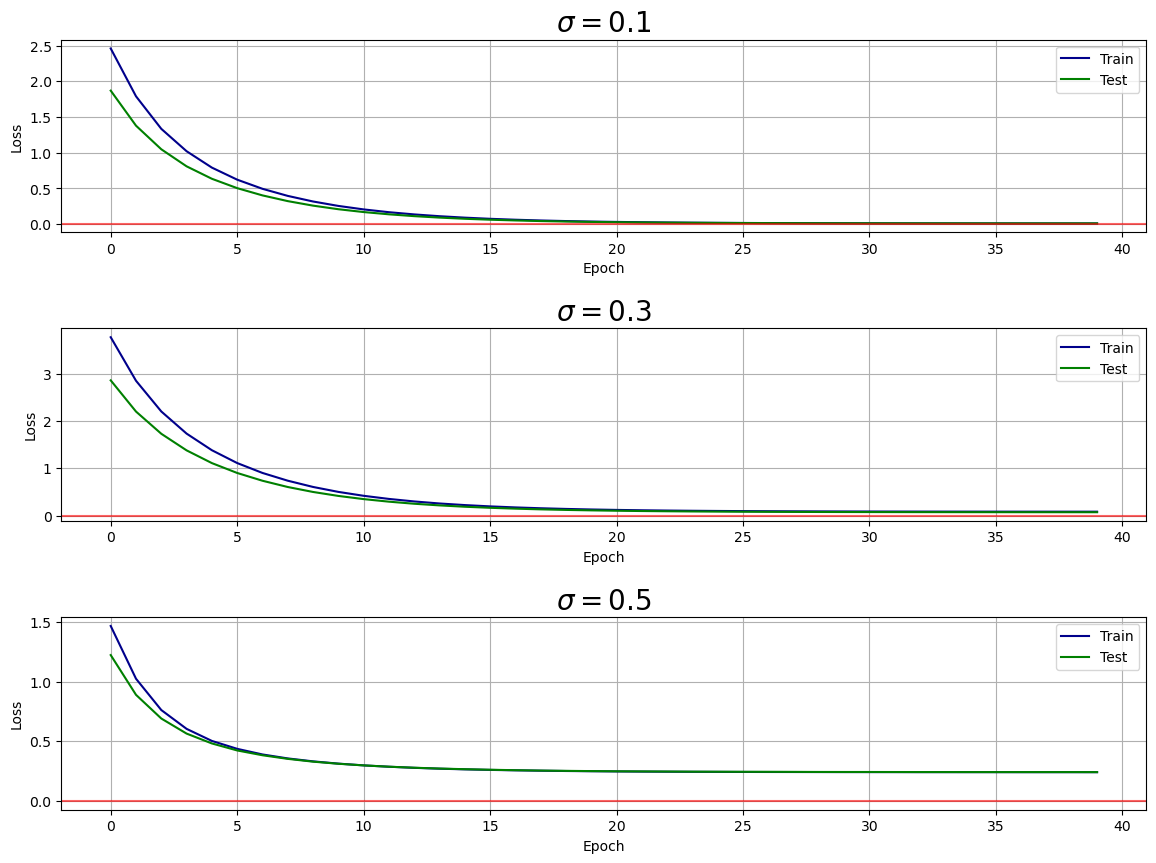

In [46]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

Nepochs = 40
models = []  # List to store the models

for i in range(3):
    model = Sequential()
    model.add(Dense(1, input_shape=(1,)))

    # compile the model choosing optimizer, loss, and metrics objects
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

    # create history
    history = model.fit(
        x=x_train,
        y=y_train[i],
        batch_size=32,
        epochs=Nepochs,
        shuffle=True,
        validation_data=(x_valid, y_valid[i]),
        verbose=0
    )
    
    # evaluate model
    score = model.evaluate(x_valid, y_valid[i], batch_size=32, verbose=1)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    models.append(model)  # Save the model in the list

    plt.subplot(3, 1, i + 1)
    plt.plot(history.history['loss'], color="darkblue")
    plt.plot(history.history['val_loss'], color="green")
    plt.axhline(0, color='red', alpha=0.6)
    plt.title("$\sigma=$" + sigmas[i], fontsize=20)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')

    plt.grid(True)
    
plt.subplots_adjust(hspace=0.5)  
plt.show()


Notiamo che in tutti e tre i casi la velocità di convergenza è piuttosto simile, mentre man mano che si aumenta il rumore ovviamente tende ad aumentare il costo complessivo tra i parametri migliori. Anche se non ci sono grafici dedicati, si può notare che diminuendo il numero di dati di training sono necessarie più epoche per far convergere la rete neurale verso i parametri che minimizzano la funzione di costo.

Mostriamo ora le predizioni fatte dalle rete neurale così allenata:

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


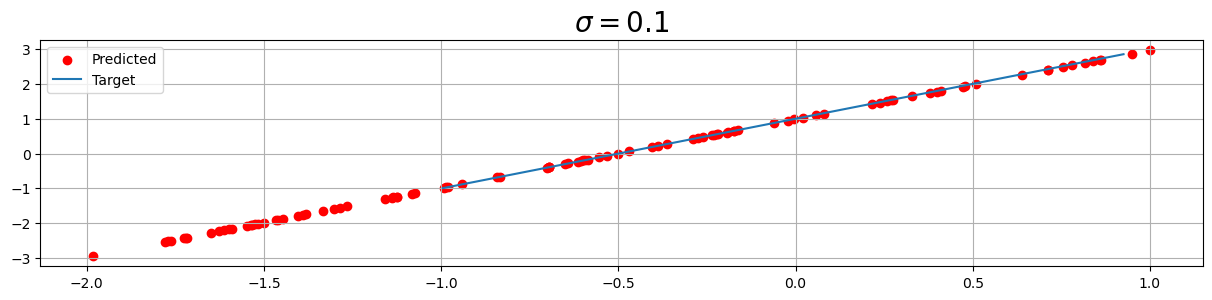

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


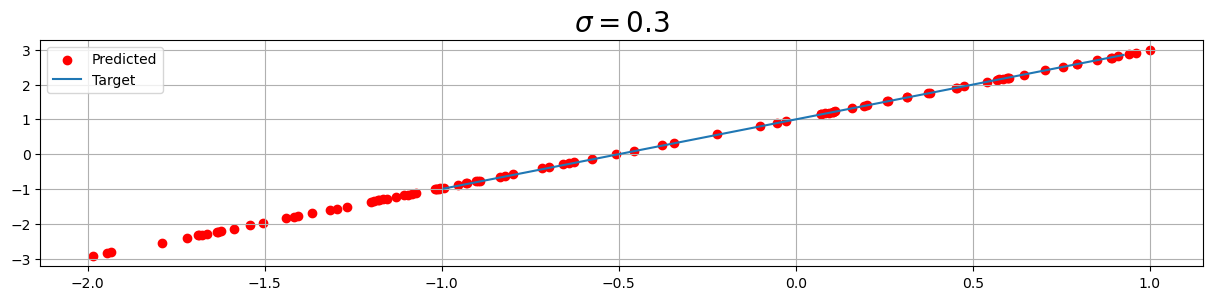

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


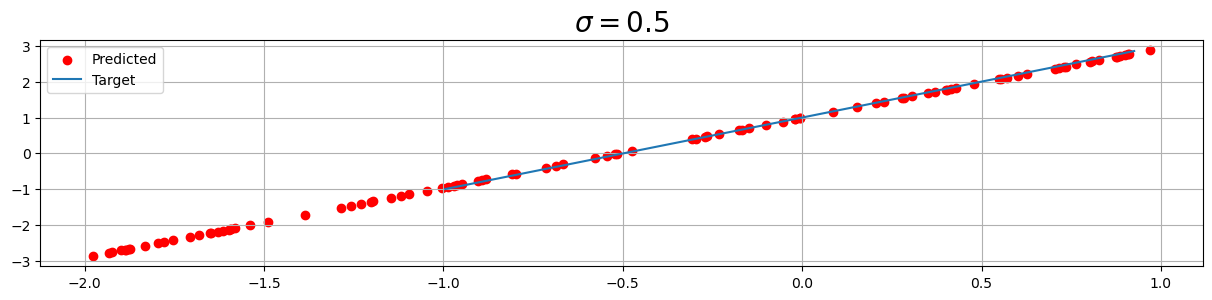

In [47]:
for i in range(3):
    plt.figure(figsize=(15, 10))    
    plt.subplot(3, 1, i + 1)
    x_predicted = np.random.uniform(-2, 1, 100)
    y_predicted = models[i].predict(x_predicted)
    plt.scatter(x_predicted, y_predicted, color='r', label='Predicted')
    plt.plot(x_valid, y_target, label='Target')
    plt.title("$\sigma=$" + sigmas[i], fontsize=20)
    plt.legend()
    plt.grid(True)
    plt.show()

Vediamo che in tutti i casi, anche per $\sigma=0.5$, la rete neurale approssima molto bene la curva iniziale. Questo è dovuto fondamentalmente al fatto che la scelta dell'architettura del NN, dovuta a una nostra conoscenza pregressa del modello, ha vincolato l'output ad essere lineare. Notiamo che per questo motivo la rete predice molto bene anche al di fuori del dominio su cui è stata allenata.

## Exercise 11.2

Estendiamo ora il modello in modo da produrre un fit della seguente cubica:

$$
f(x)=4-3x-2x^2+3x^3
$$
con $x \in [-1,1]$.

In questo caso la funzione da fittare non è lineare, quindi non basta un solo neurone in un solo strato. In base all'esercizio precedente si è scelto di fissare $\sigma = 0.2$. Mostriamo i dati di training e di test e poi i risultati ottenuti con diverse architetture della rete neurale.

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return a + b*x + c*x**2 + d*x**3

# parameters of f(x) = a+bx+cx^2+dx^3
a = 4 
b = -2 
c = -3
d = 3

# generate training inputs
Ntrain=3000
Nepochs=30
sigma=0.2

np.random.seed(0)
x_train = np.random.uniform(-1, 1, Ntrain)
x_valid = np.random.uniform(-1, 1, 300)
x_valid.sort()
y_target = f(x_valid) # ideal (target) polynomial

y_train = np.zeros((3, len(x_train)))  # Define y_train as a matrix
y_valid = np.zeros((3, len(x_valid)))  # Define y_valid as a matrix

for i in range (3):
    y_train[i] = np.random.normal(f(x_train), sigma) # actual measures from which we want to guess regression parameters
    y_valid[i] = np.random.normal(f(x_valid), sigma)

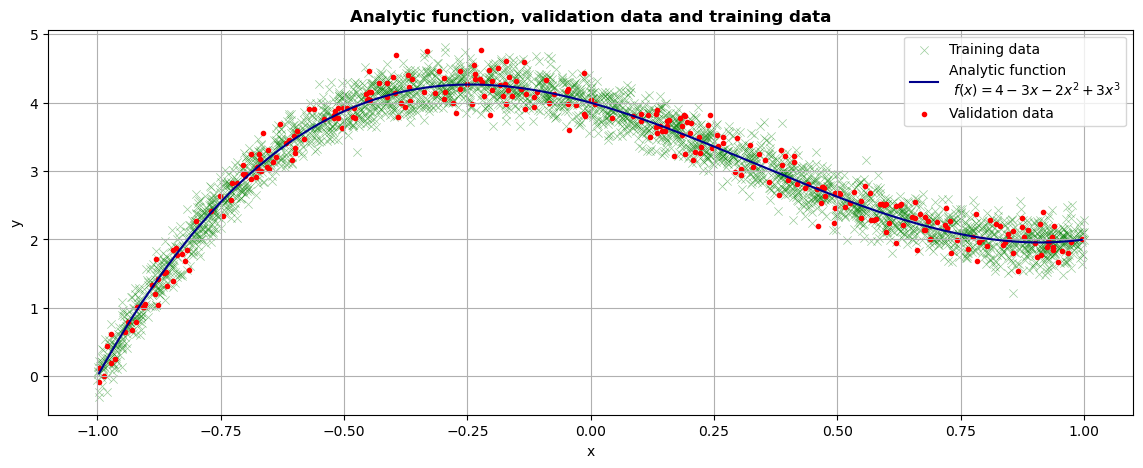

In [34]:
plt.figure(figsize=(14,5))
plt.scatter(x_train, y_train[0], marker = "x", color='green', label='Training data',linewidth=0.5, alpha=0.4)
plt.plot(x_valid, y_target, label = "Analytic function\n $f(x) = 4 - 3x - 2x^2 + 3x^3$", color="darkblue")
plt.scatter(x_valid, y_valid[0], marker = ".", color='r', label='Validation data')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Analytic function, validation data and training data", fontweight = "bold")
plt.grid()
plt.legend()
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 9.6010 - mse: 9.6010
Test loss: 10.040915489196777
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - loss: 0.0488 - mse: 0.0488
Test loss: 0.045523110777139664
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 9.3673 - mse: 9.3673
Test loss: 9.787491798400879


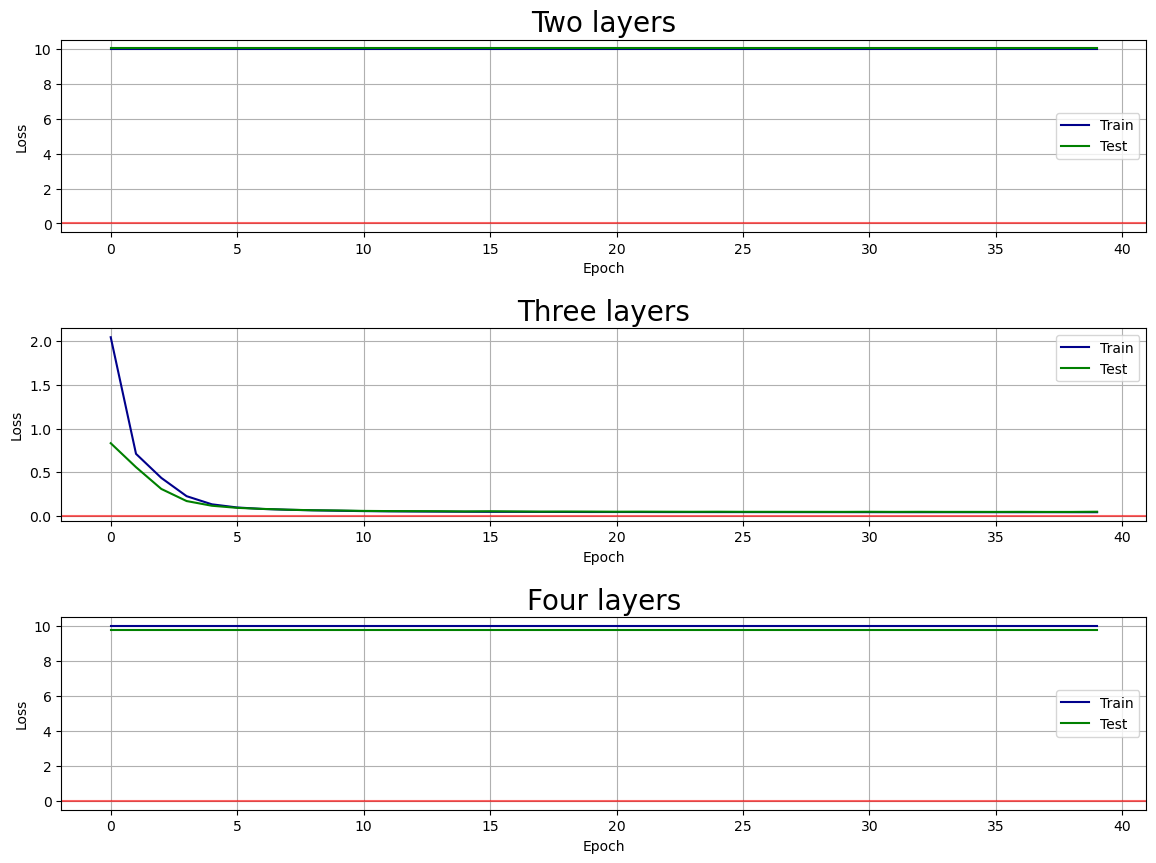

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

Nepochs = 40
models = []  # List to store the models
layers = ["Two", "Three", "Four"]

for i in range(3):
    model = Sequential()
    
    act = 'relu'
    model.add(Dense(20, input_shape=(1,), activation = act)) # nota: funzione di attivazione (esplorare quali vanno meglio)
    if (i>0):
        model.add(Dense(30, activation = act))
    if (i>1):
        model.add(Dense(30, activation = act))
    model.add(Dense(1, activation = 'relu'))

    # compile the model choosing optimizer, loss, and metrics objects
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])

    # create history
    history = model.fit(
        x=x_train,
        y=y_train[i],
        batch_size=32,
        epochs=Nepochs,
        shuffle=True,
        validation_data=(x_valid, y_valid[i]),
        verbose=0
    )
    
    # evaluate model
    score = model.evaluate(x_valid, y_valid[i], batch_size=32, verbose=1)
    print('Test loss:', score[0])
    
    models.append(model)  # Save the model in the list

    plt.subplot(3, 1, i + 1)
    plt.plot(history.history['loss'], color="darkblue")
    plt.plot(history.history['val_loss'], color="green")
    plt.axhline(0, color='red', alpha=0.6)
    plt.title(layers[i]+" layers", fontsize=20)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')

    plt.grid(True)
    
plt.subplots_adjust(hspace=0.5)  
plt.show()


Notiamo che il risultato migliore si ottiene con tre diversi layers. Diminuendo i layers aumenta il tempo di convergenza, mentre mettendone quattro il tempo di convergenza sembra leggermente minore di quello che si ha con tre livelli, con un costo però più alto. Ne deduco che una profondità di tre livelli è abbastanza per il fit richiesto. 

Al contrario ho provato a tenere due soli livelli aumentando il numero di neuroni nel primo. La procedura non ha provocato un sostanziale miglioramento, che è invece raggiunto aumentando la profondità della rete. Per quanto riguarda i metodi di ottimizzazione non ho notato particolari vantaggi nell'uso di uno o dell'altro, mentre per quanto riguarda le funzioni di attivazione le "relu" e le "elu" risultavano essere più prestanti.

Di seguito la previsione fatta dal modello a tre strati:

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


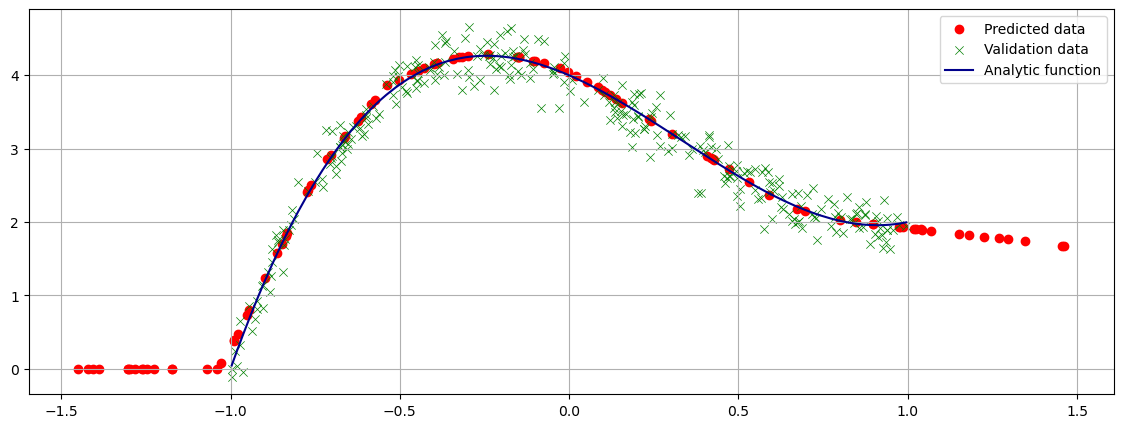

In [36]:
plt.figure(figsize=(14,5))

x_predicted = np.random.uniform(-1.5, 1.5, 100)
y_predicted = models[1].predict(x_predicted)
plt.scatter(x_predicted, y_predicted,color='r', label='Predicted data')
plt.scatter(x_valid, y_valid[1], marker = "x", color='green', label='Validation data', linewidth=0.5)
plt.plot(x_valid, f(x_valid), label='Analytic function', color="darkblue")
plt.legend()
plt.grid(True)
plt.show()

Vediamo che in questo caso, a differenza della funzione lineare, con questi metodi non c'è alcuna speranza di modellizzare la funzione al di fuori del dominio in cui la rete è stata allenata.

## Exercise 11.3
  
Estendiamo il modello per il fit di una funzione 2D come $f(x,y) = \sin(x^2+y^2)$ nel range $x \in [-3/2,3/2]$ e $y \in [-3/2,3/2]$.

Mostriamo la funzione e i punti di training e di test:

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def f(x,y):
    return np.sin(x**2+y**2)


# generate training inputs
Ntrain=10000
Nepochs=30
Nvalidation = int(Ntrain/10)
#Nvalidation = 1000
sigma=0.2

np.random.seed(0)
span=3/2

x_train = np.random.uniform(-span, span, Ntrain)
y_train = np.random.uniform(-span, span, Ntrain)

x_valid = np.random.uniform(-span, span, Nvalidation)
y_valid = np.random.uniform(-span, span, Nvalidation)

XY_train = np.column_stack((x_train,y_train))      # in the format needed
XY_valid = np.column_stack((x_valid,y_valid))      #   by `model.fit` method

z_train = np.random.normal(f(x_train,y_train), sigma) 
z_valid = np.random.normal(f(x_valid,y_valid), sigma)

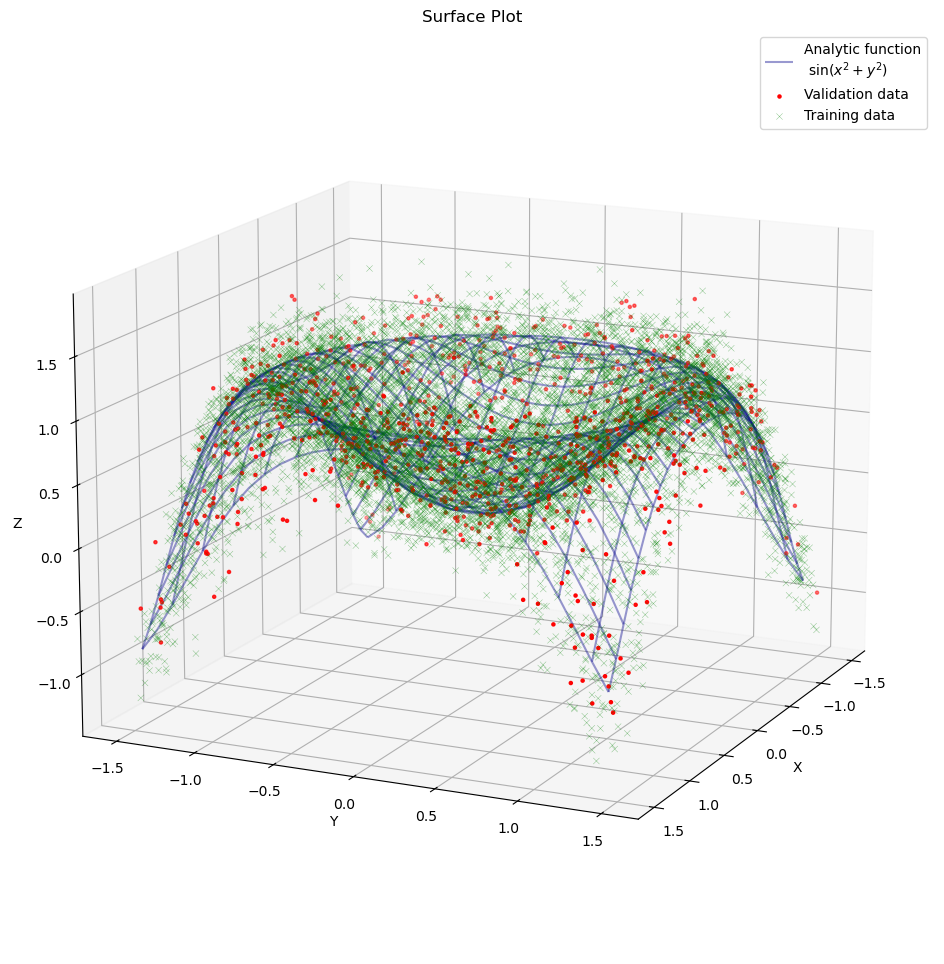

In [38]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

x_ = np.arange(-span,span, 0.1)
y_ = np.arange(-span,span, 0.1)
X_, Y_ = np.meshgrid(x_,y_)
ax.plot_wireframe(  X_, Y_, f(X_,Y_), 
                    rstride=2, label='Analytic function\n $\sin(x^2+y^2)$', color = 'darkblue',
                    alpha =0.4)

ax.scatter(x_valid, y_valid, z_valid, marker = ".", color = "r", label='Validation data')
ax.scatter(x_train, y_train, z_train, marker = "x", color = "green",
               label='Training data', linewidth=0.3, alpha = 0.5)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Surface Plot')
ax.view_init(elev=15, azim=25)  # Adjust the elevation (vertical angle) and azimuth (horizontal angle)

plt.legend()
plt.show()

In questo caso, essendo in presenza di un problema più complesso caratterizzato da uno spazio dei parametri a maggiore dimensionalità, possiamo aspettarci la necessità di aumentare la complessità della rete neurale aumentando neuroni e strati. Ho fatto un po' di prove e quattro strati con un buon numero di neuroni nei primi sembra garantire un ottimo fit.

In [39]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

model = tf.keras.Sequential()

act = 'tanh'
model.add(Dense(40, input_shape=(2,), activation = act)) # nota: funzione di attivazione (esplorare quali vanno meglio)
model.add(Dense(30, activation = act))
model.add(Dense(20, activation = act))
model.add(Dense(1, activation = act))


# compile the model choosing optimizer, loss and metrics objects
model.compile(optimizer='nadam', loss='mse', metrics=['mse'])

In [40]:
history = model.fit(x=XY_train, y=z_train, 
          batch_size=32, epochs=Nepochs,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(XY_valid, z_valid),verbose=0)

In [41]:
# evaluate model
score = model.evaluate(XY_valid, z_valid, batch_size=32, verbose=0)
#verbose=1: It controls the verbosity mode. In this case, verbose=1 means that the evaluation 
#progress and results will be displayed during the evaluation.

# print performance
print()
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.042302969843149185
Test accuracy: 0.042302969843149185


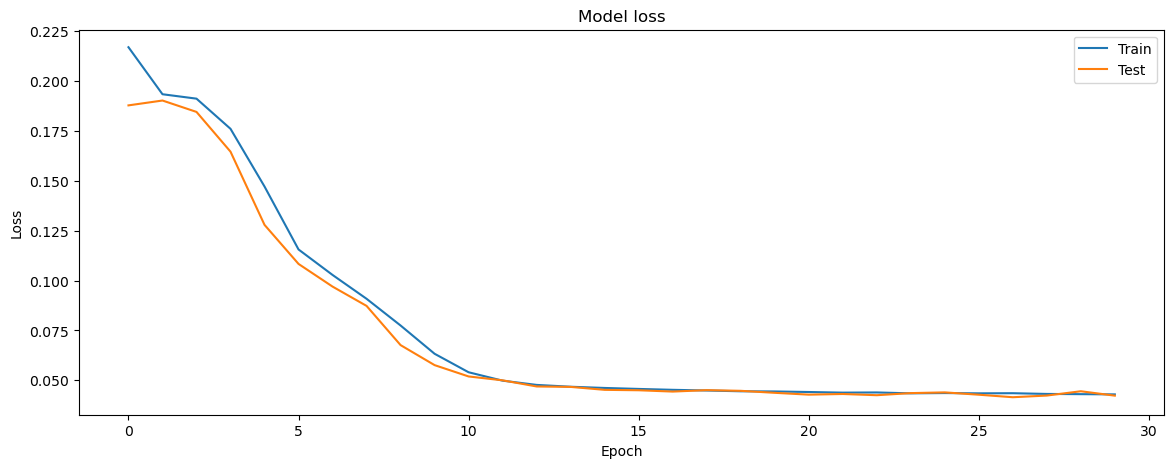

In [42]:
# look into training history
# Plot training & validation loss values
plt.figure(figsize=(14,5))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

Notiamo che per questo problema servono più generazioni perché i pesi e i bias si stabilizzino. Questo comportamento era prevedibile sulla abse della maggiore complessità del problema.

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step


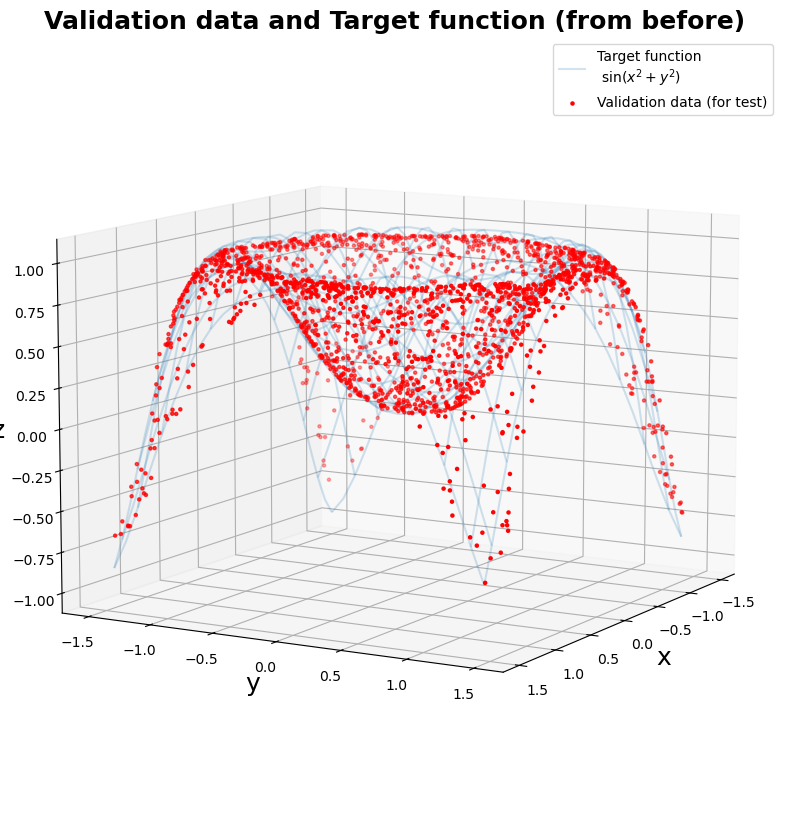

In [43]:
# generate predictions
x_predicted = np.random.uniform(-span, span, 2000) 
y_predicted = np.random.uniform(-span, span, 2000) 
XY_predicted = np.column_stack((x_predicted,y_predicted))
z_predicted = model.predict(XY_predicted)

# plot
x_ = np.arange(-span,span, 0.1)
y_ = np.arange(-span,span, 0.1)
X_, Y_ = np.meshgrid(x_,y_)

fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111, projection='3d')
fig.add_axes(ax)
ax.plot_wireframe(  X_, Y_, f(X_,Y_), 
                    rstride=2, cstride=2, 
                    label='Target function\n $\sin(x^2+y^2)$',
                    alpha = 0.2)
ax.scatter(x_predicted, y_predicted, z_predicted, marker = ".", color = "r", label='Validation data (for test)')
ax.set_xlabel("x", fontsize = 18)
ax.set_ylabel("y", fontsize = 18)
ax.set_zlabel("z", fontsize = 18)
plt.title("Validation data and Target function (from before)", fontsize = 18, fontweight = "bold")
ax.legend()
ax.view_init(10, 30)


plt.show()


Notiamo un ottimo fit su tutto il dominio di allenamento. Il maggiore problema che ho riscontrato è stato quello di avere un buon fit sulle code. Ho notato che aumentare gli strati, il numero di neuroni e il numero delle epoche non aveva una grande influenza su questo aspetto. L'unico modo efficace è stato impostare l'ottimizzatore su "nadam" (anche "adam" funzionava abbastanza bene). Probabilmente la difficoltà è da ricercare nella scarsità di dati che descrivono le code rispetto al resto della funzione.